In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import firedrake
import icepack, icepack.plot, icepack.models

In [2]:
Lx, Ly = 20e3, 20e3
nx, ny = 16, 16

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)

<IPython.core.display.Javascript object>


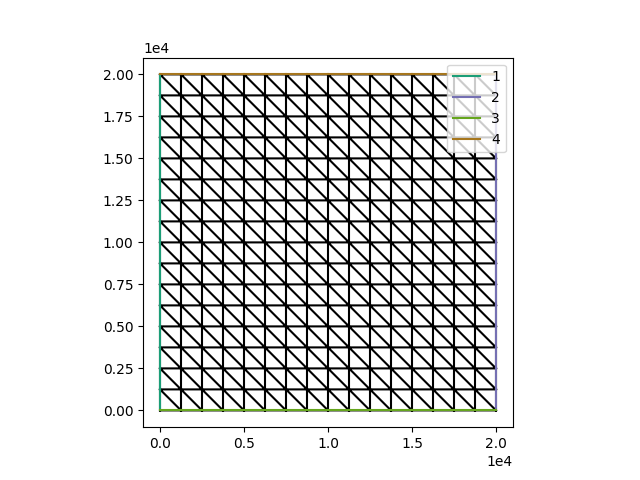

In [3]:
fig, axes = icepack.plot.subplots()
icepack.plot.triplot(mesh, axes=axes)
fig.show()

In [4]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2) #thickness,scalar
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2) #velocity, vector

In [19]:
x, y = firedrake.SpatialCoordinate(mesh)
# meters
h0, δh = 500.0, 100.0
h = firedrake.interpolate(h0 - δh*x/Lx,Q) #thickness
# meters/year
u0 = 100.0
u = firedrake.interpolate(firedrake.as_vector((u0+100*x/Lx,0)),V) #intial guess velocity (linear)
# degrees K
T = 254.15
A = firedrake.Constant(icepack.rate_factor(T))
# meters/year
a = -2.5

<IPython.core.display.Javascript object>


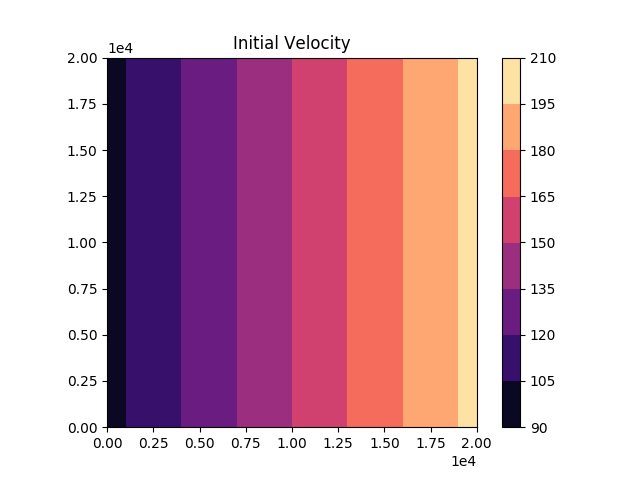

Text(0.5, 1.0, 'Initial Velocity')

In [20]:
fig,ax = icepack.plot.subplots()
contours = icepack.plot.tricontourf(u,cmap='magma',axes = ax)
colorbar = fig.colorbar(contours)
ax.set_title('Initial Velocity')

<IPython.core.display.Javascript object>


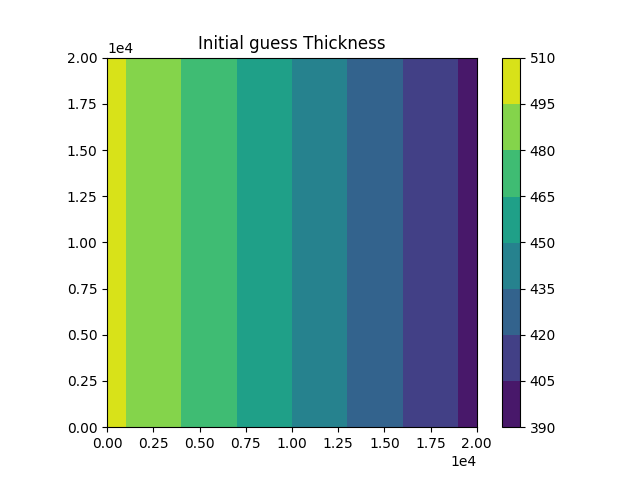

Text(0.5, 1.0, 'Initial guess Thickness')

In [18]:
fig,ax = icepack.plot.subplots()
contours = icepack.plot.tricontourf(h,axes=ax)
plt.colorbar(contours)
ax.set_title('Initial guess Thickness')

In [21]:
ice_shelf = icepack.models.IceShelf()
help(ice_shelf)

Help on IceShelf in module icepack.models.ice_shelf object:

class IceShelf(builtins.object)
 |  IceShelf(viscosity=<function viscosity_depth_averaged at 0x7f678c276488>, gravity=<function gravity at 0x7f678c276510>, terminus=<function terminus at 0x7f678c2769d8>, side_friction=<function side_friction at 0x7f678c276730>, penalty=<function normal_flow_penalty at 0x7f678c2767b8>)
 |  
 |  Class for modelling the flow of floating ice shelves
 |  
 |  This class provides functions that solve for the velocity and
 |  thickness of a floating ice shelf. The relevant physics can be found
 |  in ch. 6 of Greve and Blatter.
 |  
 |  .. seealso::
 |     :py:func:`icepack.models.viscosity.viscosity_depth_averaged`
 |        Default implementation of the ice shelf viscous action
 |  
 |  Methods defined here:
 |  
 |  __init__(self, viscosity=<function viscosity_depth_averaged at 0x7f678c276488>, gravity=<function gravity at 0x7f678c276510>, terminus=<function terminus at 0x7f678c2769d8>, side_fric

In [22]:
opts = {'dirichlet_ids':[1], 'side_wall_ids': [3,4], 'tol': 1e-8}
#side wall condition states that velocity cannot cross the wall, but can move along
u = ice_shelf.diagnostic_solve(u0=u,h=h,A=A,**opts)

<IPython.core.display.Javascript object>


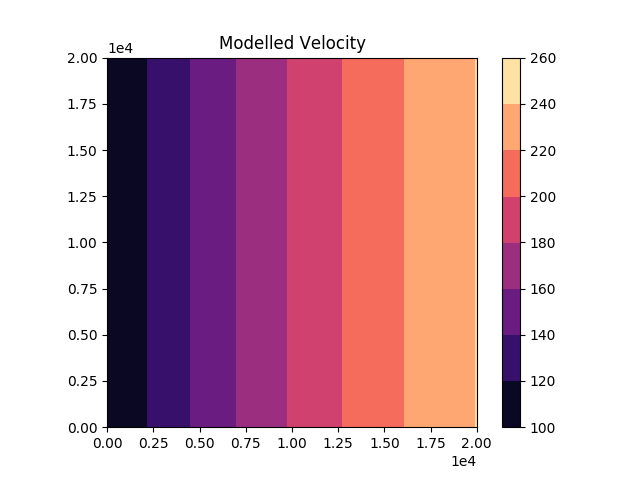

Text(0.5, 1.0, 'Modelled Velocity')

In [23]:
fig,ax = icepack.plot.subplots()
contours = icepack.plot.tricontourf(u,cmap='magma',axes = ax)
colorbar = fig.colorbar(contours)
ax.set_title('Modelled Velocity')

In [26]:
#prognostic solver
δT = 1.0/12
final_time = 2
a = firedrake.Constant(-2.5)
num_timesteps = int(final_time/ δT)
for step in range(num_timesteps):
    h = ice_shelf.prognostic_solve(δT,h0=h,u=u,a=a)
    u = ice_shelf.diagnostic_solve(u0=u,h=h,A=A,**opts)
    
    print('.',end='')

........................

<IPython.core.display.Javascript object>


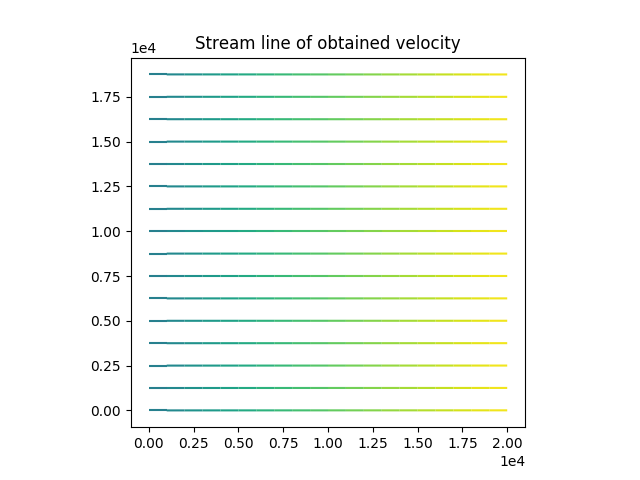

Text(0.5, 1.0, 'Stream line of obtained velocity')

In [29]:
fig,ax = icepack.plot.subplots()
contours = icepack.plot.streamplot(u,precision=1000, density=1000,axes=ax)
ax.set_title('Stream line of obtained velocity')
#precision is how close to integrate the 
#density is how close

<IPython.core.display.Javascript object>


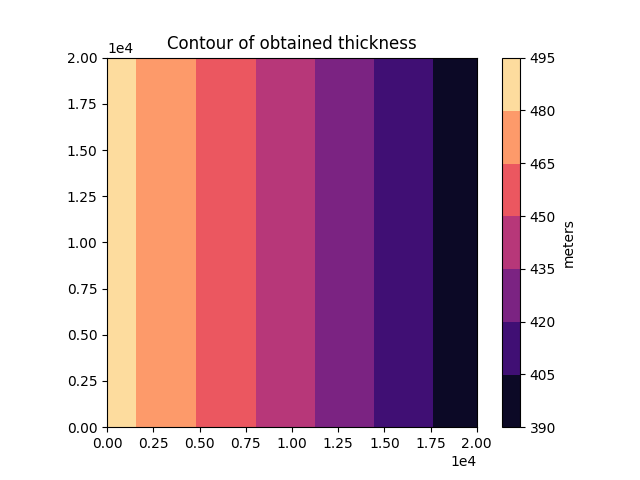

In [31]:
fig,ax = icepack.plot.subplots()
contours = icepack.plot.tricontourf(h,cmap='magma',axes=ax)
ax.set_title('Contour of obtained thickness')
cbar = fig.colorbar(contours,label='meters')
#precision is how close to integrate the 

<IPython.core.display.Javascript object>


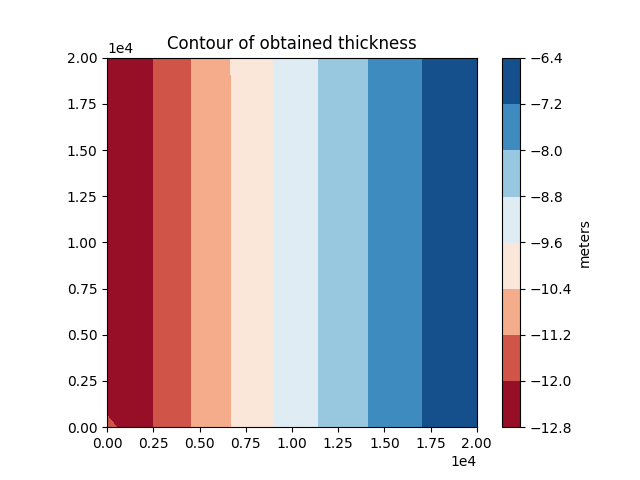

In [35]:
h_initial = firedrake.interpolate(h0- δh *x/Lx,Q)
h_change = firedrake.interpolate(h-h_initial,Q)
fig,ax = icepack.plot.subplots()
contours = icepack.plot.tricontourf(h_change,cmap='RdBu',axes=ax)
ax.set_title('Contour of obtained thickness')
cbar = fig.colorbar(contours,label='meters')
#precision is how close to integrate the 

In [36]:
help(icepack.models)

Help on package icepack.models in icepack:

NAME
    icepack.models

DESCRIPTION
    # Copyright (C) 2017-2019 by Daniel Shapero <shapero@uw.edu>
    #
    # This file is part of icepack.
    #
    # icepack is free software: you can redistribute it and/or modify
    # it under the terms of the GNU General Public License as published by
    # the Free Software Foundation, either version 3 of the License, or
    # (at your option) any later version.
    #
    # The full text of the license can be found in the file LICENSE in the
    # icepack source directory or at <http://www.gnu.org/licenses/>.

PACKAGE CONTENTS
    friction
    heat_transport
    hybrid
    ice_shelf
    ice_stream
    mass_transport
    viscosity

FILE
    /opt/conda/envs/firedrake/firedrake-venv/src/icepack/icepack/models/__init__.py




In [ ]:
#hybrid can be used for land terminating glaciers
#ice shelf is always upshelf but the stream can have a shelf attached to it
#ice stream is with Weertman sliding
